### Load Data

In [1]:
import pandas as pd
import re

courses_prices = pd.read_csv('./Data/course_prices.csv')
courses = pd.read_csv('./Data/Coursera_courses.csv')
users = pd.read_csv('./Data/Coursera_reviews.csv')
courses_metadata = pd.read_csv('./Data/CourseraDataset-Unclean.csv')
job_skills = pd.read_csv('./Data/job_skills.csv')
job_metadata = pd.read_csv('./Data/linkedin_job_postings.csv')

In [2]:
courses

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being
3,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals
4,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,google-cbrs-cpi-training
...,...,...,...,...
618,Accounting Data Analytics with Python,University of Illinois at Urbana-Champaign,https://www.coursera.org/learn/accounting-data...,accounting-data-analytics-python
619,Introduction to Molecular Spectroscopy,University of Manchester,https://www.coursera.org/learn/spectroscopy,spectroscopy
620,Managing as a Coach,"University of California, Davis",https://www.coursera.org/learn/managing-as-a-c...,managing-as-a-coach
621,The fundamentals of hotel distribution,ESSEC Business School,https://www.coursera.org/learn/hotel-distribution,hotel-distribution


In [3]:
users

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training
...,...,...,...,...,...
1454706,g,By Brijesh K,"Aug 25, 2020",5,computer-networking
1454707,.,By Vasavi V M,"Jul 02, 2020",5,computer-networking
1454708,.,By Drishti D,"Jun 20, 2020",5,computer-networking
1454709,.,By FAUSTINE F K,"Jun 07, 2020",5,computer-networking


In [4]:
courses_metadata

,Course Title,Rating,Level,Duration,Schedule,Review,What you will learn,Skill gain,Modules,Instructor,Offered By,Keyword,Course Url
0,Fashion as Design,4.8,Beginner level,20 hours (approximately),Flexible schedule,"2,813 reviews",NaN,"['Art History', 'Art', 'History', 'Creativity']","['Introduction', 'Heroes', 'Silhouettes', 'Cou...","['Anna Burckhardt', 'Paola Antonelli', 'Michel...",['The Museum of Modern Art'],Arts and Humanities,https://www.coursera.org/learn/fashion-design
1,Modern American Poetry,4.4,Beginner level,Approx. 34 hours to complete,Flexible schedule,100 reviews,NaN,[],"['Orientation', 'Module 1', 'Module 2', 'Modul...",['Cary Nelson'],['University of Illinois at Urbana-Champaign'],Arts and Humanities,https://www.coursera.org/learn/modern-american...
2,Pixel Art for Video Games,4.5,Beginner level,9 hours (approximately),Flexible schedule,227 reviews,NaN,[],"['Week 1: Introduction to Pixel Art', 'Week 2:...","['Andrew Dennis', 'Ricardo Guimaraes']",['Michigan State University'],Arts and Humanities,https://www.coursera.org/learn/pixel-art-video...
3,Distribución digital de la música independiente,NaN,Beginner level,Approx. 8 hours to complete,Flexible schedule,NaN,NaN,[],"['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4']",['Eduardo de la Vara Brown.'],['SAE Institute México'],Arts and Humanities,https://www.coursera.org/learn/distribucion-di...
4,The Blues: Understanding and Performing an Ame...,4.8,Beginner level,Approx. 11 hours to complete,Flexible schedule,582 reviews,Students will be able to describe the blues as...,"['Music', 'Chord', 'Jazz', 'Jazz Improvisation']","['Blues Progressions – Theory and Practice ', ...",['Dariusz Terefenko'],['University of Rochester'],Arts and Humanities,https://www.coursera.org/learn/the-blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9590,Power Onboarding,4.1,Beginner level,Approx. 7 hours to complete,Flexible schedule,36 reviews,NaN,[],"['Week 1 - Get Ready', 'Session 2 - Get Set', ...",['William J. White'],['Northwestern University'],Social Sciences,https://www.coursera.org/learn/power-onboarding
9591,Implementing Parent Feedback with Google Forms,4.9,Beginner level,NaN,NaN,77 reviews,Creating engaging parent surveys using Google ...,"['Education', 'online tools', 'engagement', 'e...",['Learn step-by-step'],['Rachel Lindsay'],['Coursera Project Network'],Social Sciences,https://www.coursera.org/projects/education-fe...
9592,"""Making"" Progress Teach-Out",4.2,Beginner level,Approx. 5 hours to complete,Flexible schedule,10 reviews,NaN,[],"['Week 1', 'WEEK 2']",['Pablo Palomino'],['Emory University'],Social Sciences,https://www.coursera.org/learn/makingprogress
9593,Use Microsoft PowerPoint to Create a Visual Sc...,4.5,Beginner level,1 hour,NaN,11 reviews,Learn about choice boards and their use within...,"['Teaching tools', 'elementary teaching', 'eng...",['Learn step-by-step'],['Rachel Lindsay'],['Coursera Project Network'],Social Sciences,https://www.coursera.org/projects/use-microsof...


In [5]:
job_metadata

,job_link,last_processed_time,got_summary,got_ner,is_being_worked,job_title,company,job_location,first_seen,search_city,search_country,search_position,job_level,job_type
0,https://www.linkedin.com/jobs/view/account-exe...,2024-01-21 07:12:29.00256+00,t,t,f,Account Executive - Dispensing (NorCal/Norther...,BD,"San Diego, CA",2024-01-15,Coronado,United States,Color Maker,Mid senior,Onsite
1,https://www.linkedin.com/jobs/view/registered-...,2024-01-21 07:39:58.88137+00,t,t,f,Registered Nurse - RN Care Manager,Trinity Health MI,"Norton Shores, MI",2024-01-14,Grand Haven,United States,Director Nursing Service,Mid senior,Onsite
2,https://www.linkedin.com/jobs/view/restaurant-...,2024-01-21 07:40:00.251126+00,t,t,f,RESTAURANT SUPERVISOR - THE FORKLIFT,Wasatch Adaptive Sports,"Sandy, UT",2024-01-14,Tooele,United States,Stand-In,Mid senior,Onsite
3,https://www.linkedin.com/jobs/view/independent...,2024-01-21 07:40:00.308133+00,t,t,f,Independent Real Estate Agent,Howard Hanna | Rand Realty,"Englewood Cliffs, NJ",2024-01-16,Pinehurst,United States,Real-Estate Clerk,Mid senior,Onsite
4,https://www.linkedin.com/jobs/view/group-unit-...,2024-01-19 09:45:09.215838+00,f,f,f,Group/Unit Supervisor (Systems Support Manager...,"IRS, Office of Chief Counsel","Chamblee, GA",2024-01-17,Gadsden,United States,Supervisor Travel-Information Center,Mid senior,Onsite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348449,https://www.linkedin.com/jobs/view/registered-...,2024-01-20 15:21:07.786118+00,t,t,f,Registered Nurse (RN) #CP-RN-7998660 - 2411627...,TravelNurseSource,"Providence, RI",2024-01-14,Fall River,United States,Nurse Supervisor,Mid senior,Onsite
1348450,https://www.linkedin.com/jobs/view/constructio...,2024-01-20 15:21:10.885264+00,t,t,f,Construction Superintendent,Jobot,"New Iberia, LA",2024-01-15,Lafayette,United States,Assistant Construction Superintendent,Mid senior,Onsite
1348451,https://www.linkedin.com/jobs/view/executive-c...,2024-01-21 07:40:00.304641+00,t,t,f,"Executive Chef, Operations Support",NEXDINE Hospitality,"Riverhead, NY",2024-01-14,Eastport,United States,Chef,Mid senior,Onsite
1348452,https://www.linkedin.com/jobs/view/rn-register...,2024-01-21 00:38:39.816821+00,t,t,f,"RN- Registered Nurse, Analyst - - 23934913EXPP...",TravelNurseSource,"Aurora, CO",2024-01-16,Colorado,United States,Occupational Analyst,Mid senior,Onsite


In [6]:
job_skills

,job_link,job_skills
0,https://www.linkedin.com/jobs/view/housekeeper...,"Building Custodial Services, Cleaning, Janitor..."
1,https://www.linkedin.com/jobs/view/assistant-g...,"Customer service, Restaurant management, Food ..."
2,https://www.linkedin.com/jobs/view/school-base...,"Applied Behavior Analysis (ABA), Data analysis..."
3,https://www.linkedin.com/jobs/view/electrical-...,"Electrical Engineering, Project Controls, Sche..."
4,https://www.linkedin.com/jobs/view/electrical-...,"Electrical Assembly, Point to point wiring, St..."
...,...,...
1296376,https://www.linkedin.com/jobs/view/community-a...,"Communication Skills, Time Management, Custome..."
1296377,https://www.linkedin.com/jobs/view/sr-it-analy...,"Windows SQL, EDI X12, Edifecs Platform, Health..."
1296378,https://www.linkedin.com/jobs/view/operations-...,"Adaptability, Communication, Digital Fluency, ..."
1296379,https://www.linkedin.com/jobs/view/float-patie...,"CNA, EMT, BLS, Medical Assistant, CPCT, LPN, R..."


### Remove Duplicate Courses

In [7]:
courses_metadata.rename(columns={'Course Title': 'name'}, inplace = True)
courses_metadata.drop_duplicates(subset=['name'], inplace=True)

### Remove Duplicate Reviews

In [8]:
users.drop_duplicates(subset=['reviews', 'reviewers', 'course_id'], inplace=True)

### Handle Null Values

In [9]:
#print(job_skills.isnull().sum())
#print(courses.isnull().sum())
#print(users.isnull().sum())
job_skills = job_skills.dropna(subset=['job_skills'])

### Merge Courses with Users by course_id

In [10]:
temp = pd.merge(users, courses, on="course_id", how="inner")
#temp.head()

In [11]:
temp

,reviews,reviewers,date_reviews,rating,course_id,name,institution,course_url
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...
...,...,...,...,...,...,...,...,...
519923,Great teacher!,By George B S,"Jul 16, 2018",5,technical-support-fundamentals,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...
519924,Very satisfied,By Abubakarr K,"Jun 13, 2018",5,technical-support-fundamentals,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...
519925,awesome course,By MD. I H,"May 28, 2018",5,technical-support-fundamentals,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...
519926,Comprehensive!,By James K,"May 28, 2018",5,technical-support-fundamentals,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...


In [12]:
courses_metadata

,name,Rating,Level,Duration,Schedule,Review,What you will learn,Skill gain,Modules,Instructor,Offered By,Keyword,Course Url
0,Fashion as Design,4.8,Beginner level,20 hours (approximately),Flexible schedule,"2,813 reviews",NaN,"['Art History', 'Art', 'History', 'Creativity']","['Introduction', 'Heroes', 'Silhouettes', 'Cou...","['Anna Burckhardt', 'Paola Antonelli', 'Michel...",['The Museum of Modern Art'],Arts and Humanities,https://www.coursera.org/learn/fashion-design
1,Modern American Poetry,4.4,Beginner level,Approx. 34 hours to complete,Flexible schedule,100 reviews,NaN,[],"['Orientation', 'Module 1', 'Module 2', 'Modul...",['Cary Nelson'],['University of Illinois at Urbana-Champaign'],Arts and Humanities,https://www.coursera.org/learn/modern-american...
2,Pixel Art for Video Games,4.5,Beginner level,9 hours (approximately),Flexible schedule,227 reviews,NaN,[],"['Week 1: Introduction to Pixel Art', 'Week 2:...","['Andrew Dennis', 'Ricardo Guimaraes']",['Michigan State University'],Arts and Humanities,https://www.coursera.org/learn/pixel-art-video...
3,Distribución digital de la música independiente,NaN,Beginner level,Approx. 8 hours to complete,Flexible schedule,NaN,NaN,[],"['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4']",['Eduardo de la Vara Brown.'],['SAE Institute México'],Arts and Humanities,https://www.coursera.org/learn/distribucion-di...
4,The Blues: Understanding and Performing an Ame...,4.8,Beginner level,Approx. 11 hours to complete,Flexible schedule,582 reviews,Students will be able to describe the blues as...,"['Music', 'Chord', 'Jazz', 'Jazz Improvisation']","['Blues Progressions – Theory and Practice ', ...",['Dariusz Terefenko'],['University of Rochester'],Arts and Humanities,https://www.coursera.org/learn/the-blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8690,Architecting with Google Kubernetes Engine: Pr...,4.9,Intermediate level,14 hours (approximately),Flexible schedule,30 reviews,NaN,[],"['Introducción al curso', 'Control de acceso y...",['Google Cloud Training'],['Google Cloud'],Social Sciences,https://www.coursera.org/learn/deploying-secur...
8691,Computational Thinking for K-12 Educators: Nes...,NaN,Beginner level,11 hours (approximately),Flexible schedule,NaN,NaN,"['Education', 'want', 'Resource', 'Causality']","['Course Orientation', 'Nested If/Else Part 1'...",['Beth Simon'],['University of California San Diego'],Social Sciences,https://www.coursera.org/learn/block-programmi...
8692,Cómo combinar y analizar datos complejos,NaN,NaN,Approx. 9 hours to complete,Flexible schedule,NaN,NaN,[],"['Estimación básica', 'Modelos', 'Vinculación ...","['Richard Valliant, Ph.D.']","['University of Maryland, College Park']",Social Sciences,https://www.coursera.org/learn/data-collection...
8693,Architecting with Google Kubernetes Engine: Wo...,NaN,Intermediate level,19 hours (approximately),Flexible schedule,NaN,NaN,[],"['Introdução ao curso', 'Operações do Kubernet...",['Google Cloud Training'],['Google Cloud'],Social Sciences,https://www.coursera.org/learn/deploying-workl...


### Remove non-ASCII values in 'name' columns in dataset

In [13]:
def clean_string(value):
    return value.encode('ascii', 'ignore').decode('ascii')

temp['name'] = temp['name'].apply(clean_string)
temp['institution'] = temp['institution'].apply(clean_string)
temp['reviewers'] = temp['reviewers'].apply(clean_string)
courses_metadata['name'] = courses_metadata['name'].apply(clean_string)
courses_prices['name'] = courses_prices['name'].apply(clean_string)
courses_prices['institution'] = courses_prices['institution'].apply(clean_string)

### Preprocess all skills column

In [17]:
def preprocess_skills_and_instructor(text):
    # Normalize text: lowercase and strip leading/trailing whitespace
    text = text.lower().strip()
    # Remove single and double quotation marks
    text = re.sub(r'[\[\]\'"]', '', text)
    # Replace special characters and bullet points with empty string
    text = re.sub(r'[\t\n\r]+', '', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Split on commas and strip each skill
    skills = [skill.strip() for skill in text.split(',')]
    # Join back with a single comma
    return ', '.join(skills)

courses_metadata['Skill gain'] = courses_metadata['Skill gain'].apply(preprocess_skills_and_instructor)
courses_metadata['Instructor'] = courses_metadata['Instructor'].apply(preprocess_skills_and_instructor)
courses_metadata.head()

,name,Rating,Level,Duration,Schedule,Review,What you will learn,Skill gain,Modules,Instructor,Offered By,Keyword,Course Url
0,Fashion as Design,4.8,Beginner level,20 hours (approximately),Flexible schedule,"2,813 reviews",NaN,"art history, art, history, creativity","['Introduction', 'Heroes', 'Silhouettes', 'Cou...","['Anna Burckhardt', 'Paola Antonelli', 'Michel...",['The Museum of Modern Art'],Arts and Humanities,https://www.coursera.org/learn/fashion-design
1,Modern American Poetry,4.4,Beginner level,Approx. 34 hours to complete,Flexible schedule,100 reviews,NaN,,"['Orientation', 'Module 1', 'Module 2', 'Modul...",['Cary Nelson'],['University of Illinois at Urbana-Champaign'],Arts and Humanities,https://www.coursera.org/learn/modern-american...
2,Pixel Art for Video Games,4.5,Beginner level,9 hours (approximately),Flexible schedule,227 reviews,NaN,,"['Week 1: Introduction to Pixel Art', 'Week 2:...","['Andrew Dennis', 'Ricardo Guimaraes']",['Michigan State University'],Arts and Humanities,https://www.coursera.org/learn/pixel-art-video...
3,Distribucin digital de la msica independiente,NaN,Beginner level,Approx. 8 hours to complete,Flexible schedule,NaN,NaN,,"['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4']",['Eduardo de la Vara Brown.'],['SAE Institute México'],Arts and Humanities,https://www.coursera.org/learn/distribucion-di...
4,The Blues: Understanding and Performing an Ame...,4.8,Beginner level,Approx. 11 hours to complete,Flexible schedule,582 reviews,Students will be able to describe the blues as...,"music, chord, jazz, jazz improvisation","['Blues Progressions – Theory and Practice ', ...",['Dariusz Terefenko'],['University of Rochester'],Arts and Humanities,https://www.coursera.org/learn/the-blues


In [15]:
courses_metadata.head()

,name,Rating,Level,Duration,Schedule,Review,What you will learn,Skill gain,Modules,Instructor,Offered By,Keyword,Course Url
0,Fashion as Design,4.8,Beginner level,20 hours (approximately),Flexible schedule,"2,813 reviews",NaN,"['Art History', 'Art', 'History', 'Creativity']","['Introduction', 'Heroes', 'Silhouettes', 'Cou...","['Anna Burckhardt', 'Paola Antonelli', 'Michel...",['The Museum of Modern Art'],Arts and Humanities,https://www.coursera.org/learn/fashion-design
1,Modern American Poetry,4.4,Beginner level,Approx. 34 hours to complete,Flexible schedule,100 reviews,NaN,[],"['Orientation', 'Module 1', 'Module 2', 'Modul...",['Cary Nelson'],['University of Illinois at Urbana-Champaign'],Arts and Humanities,https://www.coursera.org/learn/modern-american...
2,Pixel Art for Video Games,4.5,Beginner level,9 hours (approximately),Flexible schedule,227 reviews,NaN,[],"['Week 1: Introduction to Pixel Art', 'Week 2:...","['Andrew Dennis', 'Ricardo Guimaraes']",['Michigan State University'],Arts and Humanities,https://www.coursera.org/learn/pixel-art-video...
3,Distribucin digital de la msica independiente,NaN,Beginner level,Approx. 8 hours to complete,Flexible schedule,NaN,NaN,[],"['Semana 1', 'Semana 2', 'Semana 3', 'Semana 4']",['Eduardo de la Vara Brown.'],['SAE Institute México'],Arts and Humanities,https://www.coursera.org/learn/distribucion-di...
4,The Blues: Understanding and Performing an Ame...,4.8,Beginner level,Approx. 11 hours to complete,Flexible schedule,582 reviews,Students will be able to describe the blues as...,"['Music', 'Chord', 'Jazz', 'Jazz Improvisation']","['Blues Progressions – Theory and Practice ', ...",['Dariusz Terefenko'],['University of Rochester'],Arts and Humanities,https://www.coursera.org/learn/the-blues


### Merge Additional Metadata with Temp dataset

In [7]:
courses_data = pd.merge(temp, courses_metadata, on="name", how="inner")

#courses_data.head()

### Filter Essential Columns in Courses Data

In [8]:
final_courses = courses_data[['reviews', 'reviewers', 'rating', 'name', 'institution', 'Rating', 'Level', 'Duration', 'Review', 'Skill gain', 'Instructor', 'What you will learn']]
final_courses = final_courses.rename(columns={ 'Rating': 'Overall Ratings', 'Review': 'Num of Reviews'})
#final_courses.head()

### Merge Datasets regarding Jobs

In [9]:
jobs_data = pd.merge(job_skills, job_metadata, on="job_link", how="inner")
#jobs_data.head()

### Filter Essential Columns in Jobs Data

In [10]:
final_jobs = jobs_data[['job_skills', 'job_title', 'search_position', 'job_level']]
final_jobs.head()
unique_values = final_jobs['search_position'].unique()
print(unique_values)
# print(unique_values.tolist())

['Cleaner' 'Clerk General' 'Consultant Education' ... 'Cleaner Wall'
 'Boat Rigger' 'Sales Representative Welding Equipment']


### Preprocess 
1) Prices
2) Remove "By' from reviewer
3) Fill in null values in level
4) get the number in duration, 
5) get the number in review, 
6) remove the list of skill gain
7) remove the list of instructor


In [11]:
final_courses['Level'].fillna('None', inplace=True)
final_courses['Duration'] = final_courses['Duration'].str.extract('(\d+)').astype(int)
final_courses['Num of Reviews'] = final_courses['Num of Reviews'].str.extract('(\d+)').astype(int)
final_courses['reviewers'] = final_courses['reviewers'].apply(lambda x: x[3:]) 
final_courses['Instructor'] = final_courses['Instructor'].apply(lambda x: x[2:-2])
# final_courses.head()

### Demean Ratings

In [12]:
reviewer_average_rating = final_courses.groupby('reviewers')['rating'].transform('mean')
final_courses['Demeaned Rating'] = final_courses['rating'] - reviewer_average_rating
# final_courses.head()

### Adding Price Column to Courses Data

In [13]:
final_courses = pd.merge(final_courses, courses_prices, on=['institution', 'name'], how='inner')
# print(final_courses.isnull().sum())
# print(final_courses.head())

### Remove empty Reviewers data

In [14]:
final_courses = final_courses[final_courses['reviewers'] != '']

### Adding Popularity to Courses Data

In [15]:
final_courses['Popularity'] = final_courses['Overall Ratings'] * final_courses['Num of Reviews']
# final_courses.head()

In [16]:
unique_counts = final_courses[final_courses['Skill gain'] != 'No Specific Skills']

print("Count of datapoints: ", unique_counts.shape)
print("Count of Unique Reviewers: ", unique_counts['reviewers'].nunique())
print("Count of Unique Courses: ", unique_counts['name'].nunique())

Count of datapoints:  (414509, 15)
Count of Unique Reviewers:  239001
Count of Unique Courses:  485


### Preprocess all skills columns 

KeyError: 'Skill gain'

### Preprocess Text Columns

## EDA

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Histogram of Number of Ratings given by each Reviewer

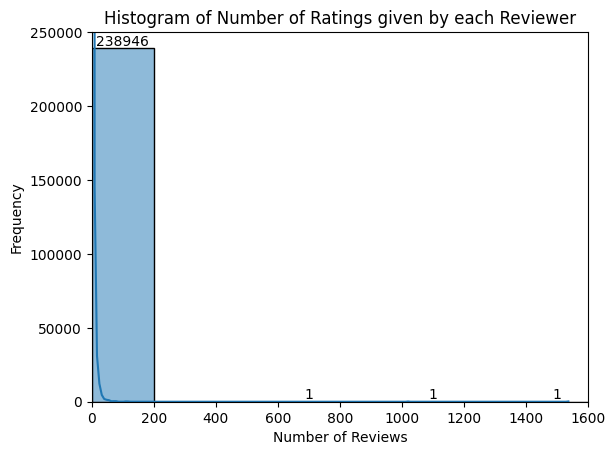

In [46]:
unique_reviewers = final_courses.groupby('reviewers').size().reset_index(name='count_of_reviews')

bin_interval = 200
bin_edges = np.arange(0, unique_reviewers['count_of_reviews'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=unique_reviewers, x='count_of_reviews', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Ratings given by each Reviewer')
plt.xlim(0, 1600)
plt.ylim(0, 250000)
plt.show()

### Explore Number of Reviews > 600 and Handle it 

In [47]:
high_review_count = unique_reviewers[unique_reviewers['count_of_reviews'] > 600]
print(high_review_count)
unique_reviewers = unique_reviewers[unique_reviewers['count_of_reviews'] < 600]

       reviewers  count_of_reviews
0                              778
1                             1020
49547  Deleted A              1537


### Remove Reviewers who have > 600 Number of Reviews from final_courses

In [48]:
final_courses = final_courses[~final_courses['reviewers'].isin(high_review_count['reviewers'])]

### Plot New Histogram of Number of Ratings given by each Reviewer

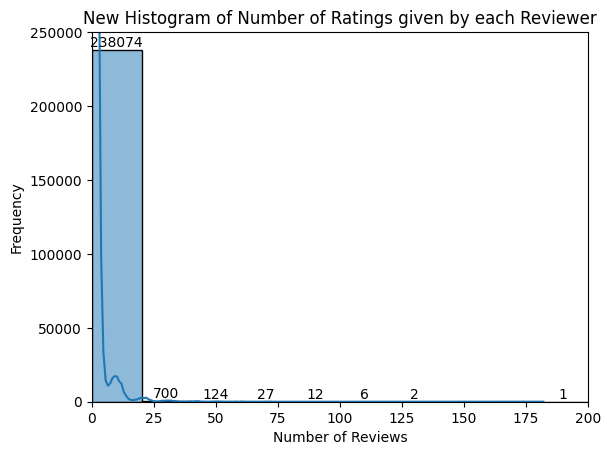

In [49]:
bin_interval = 20
bin_edges = np.arange(0, unique_reviewers['count_of_reviews'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=unique_reviewers, x='count_of_reviews', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('New Histogram of Number of Ratings given by each Reviewer')
plt.xlim(0, 200)
plt.ylim(0, 250000)
plt.show()

In [50]:
print(unique_reviewers[unique_reviewers['count_of_reviews'] == ''])

Empty DataFrame
Columns: [reviewers, count_of_reviews]
Index: []


In [51]:
final_courses.describe().round(2)

,rating,Overall Ratings,Duration,Num of Reviews,Demeaned Rating,Fee,Popularity
count,411173.00,411173.00,411173.00,411173.00,411173.00,411173.00,411173.00
mean,4.69,4.75,19.76,45.55,-0.00,50.94,217.29
std,0.71,0.12,11.97,105.06,0.46,12.99,496.38
min,1.00,3.90,2.00,1.00,-3.84,29.00,4.20
25%,5.00,4.70,11.00,4.00,0.00,49.00,19.60
50%,5.00,4.80,18.00,12.00,0.00,49.00,57.60
75%,5.00,4.80,26.00,37.00,0.00,49.00,181.30
max,5.00,4.90,127.00,980.00,3.00,777.00,4704.00


In [52]:
print("Count of datapoints: ", final_courses.shape)
print("Count of Unique Reviewers: ", final_courses['reviewers'].nunique())
print("Count of Unique Courses: ", final_courses['name'].nunique())

Count of datapoints:  (411173, 15)
Count of Unique Reviewers:  238946
Count of Unique Courses:  485


### Histogram of Popularity of each Course

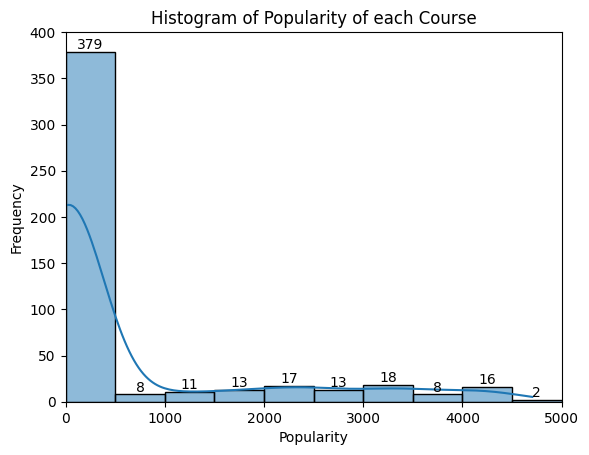

In [53]:
grouped_courses = final_courses.drop_duplicates(subset=['institution', 'name'])

bin_interval = 500
bin_edges = np.arange(0, grouped_courses['Popularity'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=grouped_courses, x='Popularity', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title('Histogram of Popularity of each Course')
plt.xlim(0, 5000)
plt.ylim(0, 400)

plt.show()


### Histogram of Count of Ratings given for each Course

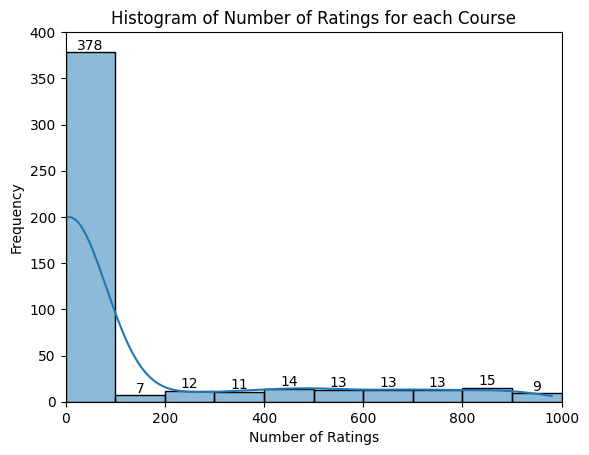

In [54]:
grouped_courses = final_courses.drop_duplicates(subset=['institution', 'name'])

bin_interval = 100
bin_edges = np.arange(0, grouped_courses['Num of Reviews'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=grouped_courses, x='Num of Reviews', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Ratings for each Course')
plt.xlim(0, 1000)
plt.ylim(0, 400)

plt.show()

### Histogram of Overall Ratings of each Course


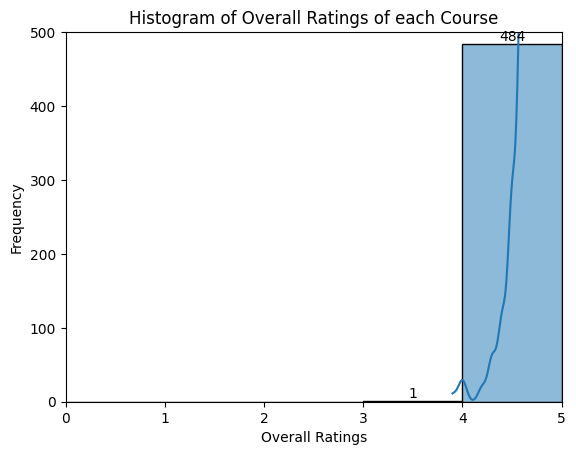

In [55]:
grouped_courses = final_courses.drop_duplicates(subset=['institution', 'name'])

bin_interval = 1
bin_edges = np.arange(0, grouped_courses['Overall Ratings'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=grouped_courses, x='Overall Ratings', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Overall Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of Overall Ratings of each Course')
plt.xlim(0, 5)
plt.ylim(0, 500)
plt.show()

### Histogram of Ratings given by Reviewers

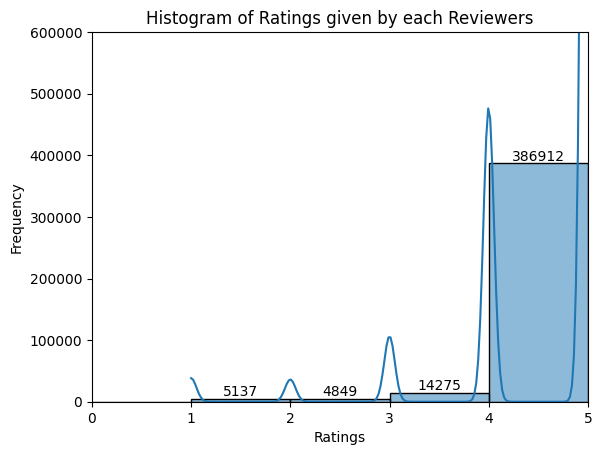

In [56]:
bin_interval = 1
bin_edges = np.arange(0, final_courses['rating'].max() + bin_interval, bin_interval)

ax = sns.histplot(data=final_courses, x='rating', bins=bin_edges, kde=True, edgecolor='black', stat='count')

for bin in ax.patches:
    if bin.get_height() > 0:
        ax.annotate(format(bin.get_height(), '.0f'), 
                    (bin.get_x() + bin.get_width() / 2., bin.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 5), 
                    textcoords = 'offset points')
    
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings given by each Reviewers')
plt.xlim(0, 5)
plt.ylim(0, 600000)
plt.show()

### Conclusion
1. Histogram of Overall Ratings for each Course and Histogram of Ratings given by each Reviewer is left skewed, implying that reviewers usually leave positive ratings. 
2. Histogram of Number of Ratings of each Course is right skewed, implying the possibility that not many reviewers would leave ratings. 

Overall, reviewers who leave a rating gave it a high score. There is a possibility that reviewers who are unhappy tend to not leave a rating. 

### Implications
1. It is hard to decipher what reviewers do not like since we do not have data regarding what they gave bad ratings for. 

### Current Solution
1. Use a demeaned rating where a demeaned rating > 0 implies that reviewers "like" the course while a demeaned rating <0 implies that reviewers "less like" the course. 